# Лабораторная работа 2
### Выполнил: Покумин Георгий Алексеевич

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm
import random

my_seed = 42
random.seed(my_seed)
np.random.seed(my_seed)

train_x = pd.read_csv("DOTA2_TRAIN_features.csv", index_col='match_id')
train_y = pd.read_csv("DOTA2_TRAIN_targets.csv", index_col='match_id')
test_x = pd.read_csv("DOTA2_TEST_features.csv", index_col='match_id')
Y = train_y[['radiant_win']]

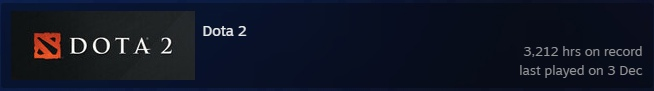

### EDA (исследовательский анализ данных)

In [29]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27772 entries, b29797296e310d2275f2cd67eeacf2eb to 8ac7bc63d5f8eba4af9a2748475ececd
Columns: 245 entries, game_time to d5_sen_placed
dtypes: float64(35), int64(210)
memory usage: 52.1+ MB


В наших данных содержатся 245 столбцов и 27772 объекта. Столбцов много, интерпретировать признаки, смотреть на их зависимости сложно, но заметим, что все признаки (изначально) являются числовыми, что немного облегчит работу.

In [30]:
for i in train_x.columns:
    print(i)

game_time
game_mode
lobby_type
objectives_len
chat_len
r1_hero_id
r1_kills
r1_deaths
r1_assists
r1_denies
r1_gold
r1_lh
r1_xp
r1_health
r1_max_health
r1_max_mana
r1_level
r1_x
r1_y
r1_stuns
r1_creeps_stacked
r1_camps_stacked
r1_rune_pickups
r1_firstblood_claimed
r1_teamfight_participation
r1_towers_killed
r1_roshans_killed
r1_obs_placed
r1_sen_placed
r2_hero_id
r2_kills
r2_deaths
r2_assists
r2_denies
r2_gold
r2_lh
r2_xp
r2_health
r2_max_health
r2_max_mana
r2_level
r2_x
r2_y
r2_stuns
r2_creeps_stacked
r2_camps_stacked
r2_rune_pickups
r2_firstblood_claimed
r2_teamfight_participation
r2_towers_killed
r2_roshans_killed
r2_obs_placed
r2_sen_placed
r3_hero_id
r3_kills
r3_deaths
r3_assists
r3_denies
r3_gold
r3_lh
r3_xp
r3_health
r3_max_health
r3_max_mana
r3_level
r3_x
r3_y
r3_stuns
r3_creeps_stacked
r3_camps_stacked
r3_rune_pickups
r3_firstblood_claimed
r3_teamfight_participation
r3_towers_killed
r3_roshans_killed
r3_obs_placed
r3_sen_placed
r4_hero_id
r4_kills
r4_deaths
r4_assists
r4_denies


Как можно заметить, большинство признаков не являются уникальными, в связи с этим можем их интерпретировать. В игре участвуют две команды, в каждой из которых по 5 игроков. Команды Radiant и Dire. Большинство признаков показывают статистики каждого игрока в матче. В связи с моим богатым опытом игры, понять, что значит каждый признак было легко. Также есть признаки, не относящиеся к отдельным игрокам:

game_time - игровое время (на текущий момент, будет объяснено позже)

game_mode - игровой режим

lobby_type - тип лобби

objectives_len - длина сообщений о каких-то игровых событиях

chat_len - длина чата

Признаки для каждого игрока:

hero_id - id героя

kills - количество убийств соперников

deaths - количество смертей

assists - количество помощей в убийствах

denies - количество отнятых у соперников крипов

gold - количество полученного золота

lh - количество добитых крипов

xp - количество полученного опыта

health - текущее здоровье героя

max_health - максимальное здоровье героя

max_mana - максимальная мана героя

level - уровень героя

x - текущая первая координата героя

y - текущая вторая координата героя

stuns - количество использованных стан-способностей

creeps_stacked - количество стакнутых крипов (стакнутых - крипы появились в одном месте)

camps_stacked - количество стакнутых лагерей

rune_pickups - количество подобранных рун

firstblood_claimed - пролил ли игрок первую кровь (количество, но на самом деле - 1 или 0)

teamfight_participation - участие в в драках

towers_killed - количество уничтоженных башен

roshans_killed - количество убитых рошанов

obs_placed - сколько игрок поставил обсервер вардов

sen_placed - сколько игрок поставил сентри вардов

Посмотрим на наши таргеты, сбалансировано ли распределены классы.

In [4]:
print(f"{set(Y['radiant_win'])}")
print(len(Y['radiant_win'])-sum(Y['radiant_win']), sum(Y['radiant_win']))

{False, True}
13251 14521


Мы имеем два сбалансированных класса, это хорошо. 

Посмотрим на пропуски в данных.

In [5]:
nan_rows = train_x.isna().sum(axis=1)
len(nan_rows[nan_rows > 0])

11394

In [6]:
train_x.columns[train_x.isna().any()]

Index(['r1_kills', 'r2_kills', 'r3_kills', 'r4_kills', 'r5_kills'], dtype='object')

Пропущенных значений очень много, но все они находятся в пяти столбцах - в убийствах игроков, скорее всего, важном признаке. Удалять строки с пустыми значениями - точно не лучшая идея.

Посмотрим на выбросы.

In [7]:
outliers = []
total_outliers = 0
for column in train_x.columns:
    lower_bound = train_x[column].quantile(0.25) - 1.5 * (train_x[column].quantile(0.75) - train_x[column].quantile(0.25))
    upper_bound = train_x[column].quantile(0.75) + 1.5 * (train_x[column].quantile(0.75) - train_x[column].quantile(0.25))
    outliers_count = train_x[(train_x[column] < lower_bound) | (train_x[column] > upper_bound)][column].count()
    outliers_percent = outliers_count / train_x.shape[0] * 100
    outliers.append(outliers_percent)
    print(f"Outliers percentage in {column}: {outliers_percent:.2f}%")

Outliers percentage in game_time: 3.41%
Outliers percentage in game_mode: 19.99%
Outliers percentage in lobby_type: 0.00%
Outliers percentage in objectives_len: 2.13%
Outliers percentage in chat_len: 8.18%
Outliers percentage in r1_hero_id: 0.00%
Outliers percentage in r1_kills: 2.59%
Outliers percentage in r1_deaths: 2.44%
Outliers percentage in r1_assists: 3.19%
Outliers percentage in r1_denies: 6.20%
Outliers percentage in r1_gold: 3.09%
Outliers percentage in r1_lh: 5.47%
Outliers percentage in r1_xp: 0.63%
Outliers percentage in r1_health: 2.79%
Outliers percentage in r1_max_health: 2.54%
Outliers percentage in r1_max_mana: 4.04%
Outliers percentage in r1_level: 0.00%
Outliers percentage in r1_x: 0.00%
Outliers percentage in r1_y: 0.00%


Outliers percentage in r1_stuns: 8.73%
Outliers percentage in r1_creeps_stacked: 15.68%
Outliers percentage in r1_camps_stacked: 15.68%
Outliers percentage in r1_rune_pickups: 4.22%
Outliers percentage in r1_firstblood_claimed: 9.08%
Outliers percentage in r1_teamfight_participation: 0.01%
Outliers percentage in r1_towers_killed: 21.75%
Outliers percentage in r1_roshans_killed: 2.75%
Outliers percentage in r1_obs_placed: 13.94%
Outliers percentage in r1_sen_placed: 23.03%
Outliers percentage in r2_hero_id: 0.00%
Outliers percentage in r2_kills: 2.47%
Outliers percentage in r2_deaths: 2.52%
Outliers percentage in r2_assists: 3.97%
Outliers percentage in r2_denies: 8.38%
Outliers percentage in r2_gold: 5.10%
Outliers percentage in r2_lh: 5.52%
Outliers percentage in r2_xp: 1.31%
Outliers percentage in r2_health: 2.71%
Outliers percentage in r2_max_health: 2.57%
Outliers percentage in r2_max_mana: 4.00%
Outliers percentage in r2_level: 0.00%
Outliers percentage in r2_x: 0.00%
Outliers per

In [8]:
outliers.sort(reverse=True)
print(outliers[0:10])

[23.451677949013394, 23.271640501224255, 23.242834509577992, 23.026789572231024, 22.80354313697249, 22.706322915166353, 22.645110182918046, 22.28863603629555, 21.975370877142446, 21.881751404292093]


Выбросы есть не во всех столбцах, но на самом деле их много, в некоторых столбцах выбросы - это 1/5 всех данных. Удалять выбросы, возможно, - не лучшая идея.

В принципе, без какого-либа препроцессинга, все данные числовые, (кроме как, заполнения пропусков, про среднее - позже) можем попробовать обучить модель и посмотреть на важность признаков. Для начала попробуем с помощью кросс-валидации подобрать лучшую модель для обучения без препроцессинга.

In [2]:
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

X = train_x.fillna(train_x.mean())

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=my_seed)

models = [CatBoostClassifier(silent=True), XGBClassifier(), LGBMClassifier(), RandomForestClassifier(),
           AdaBoostClassifier(), GradientBoostingClassifier(),
           LogisticRegression(),  KNeighborsClassifier()]
for model in models:
    cv_scores_base = cross_val_score(model, X, Y, cv=cv, scoring='roc_auc', n_jobs=-1)
    print('Base features: mean={} scores={}, model = {}'.format(cv_scores_base.mean(), 
                                                cv_scores_base, model))

Base features: mean=0.8034062641487771 scores=[0.80407556 0.80403949 0.80069242 0.8011539  0.80706996], model = <catboost.core.CatBoostClassifier object at 0x000002173A715590>
Base features: mean=0.7831813362876657 scores=[0.77888718 0.7830346  0.78531146 0.78540988 0.78326356], model = XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              nu

Видим, что лучше всего себя показали модели, использующие градиентный бустинг. Логистическая регрессия тоже показала себя неплохо. Возьмем CatBoost, так как у этой модели самые лучшие результаты. Попробуем обучить модель, и достать из нее признаки. CatBoost считает важно признаков, учитывая то, как часто этот признак используется в разделении и то, насколько сильно этот признак улучшает показатели модели.

In [10]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(silent=True)
model.fit(X, Y)
feature_importance = pd.DataFrame({'feature': X.columns, 'importance':model.get_feature_importance()}).sort_values('importance')

In [11]:
top_10_high_importance = feature_importance.nlargest(10, 'importance')
top_10_low_importance = feature_importance.nsmallest(10, 'importance')
print("Top 10 features with highest importance:")
print(top_10_high_importance)
print("\nTop 10 features with lowest importance:")
print(top_10_low_importance)

Top 10 features with highest importance:
       feature  importance
82     r4_gold    1.588543
199  d4_deaths    1.573340
226    d5_gold    1.530260
103  r5_deaths    1.266336
10     r1_gold    1.220048
31   r2_deaths    1.207445
66        r3_y    1.206473
154    d2_gold    1.201712
178    d3_gold    1.199214
79   r4_deaths    1.193208

Top 10 features with lowest importance:
                   feature  importance
194      d3_roshans_killed    0.000000
167  d2_firstblood_claimed    0.000000
191  d3_firstblood_claimed    0.000000
119  r5_firstblood_claimed    0.000000
98       r4_roshans_killed    0.000000
21        r1_camps_stacked    0.000000
93        r4_camps_stacked    0.000000
239  d5_firstblood_claimed    0.000000
117       r5_camps_stacked    0.001201
147          d1_obs_placed    0.001796


Как видим, больше всего в "сырых данных" влияет количество золота у каждого игрока. Меньше всего влияет пролил ли игрок первую кровь, что в принципе хорошо кореллирует с реальной игрой в доту. Попробуем узнать побольше влиятельных признаков.

In [12]:
top_30_high_importance = feature_importance.nlargest(30, 'importance')
print("Top 30 features with highest importance:")
print(top_30_high_importance)

Top 30 features with highest importance:
       feature  importance
82     r4_gold    1.588543
199  d4_deaths    1.573340
226    d5_gold    1.530260
103  r5_deaths    1.266336
10     r1_gold    1.220048
31   r2_deaths    1.207445
66        r3_y    1.206473
154    d2_gold    1.201712
178    d3_gold    1.199214
79   r4_deaths    1.193208
203      d4_lh    1.159751
130    d1_gold    1.120781
106    r5_gold    1.097827
186       d3_y    1.088159
131      d1_lh    1.044634
65        r3_x    1.013736
151  d2_deaths    1.011814
7    r1_deaths    1.008865
223  d5_deaths    0.986335
175  d3_deaths    0.970472
37   r2_health    0.952012
209       d4_x    0.941076
33   r2_denies    0.937519
127  d1_deaths    0.928065
113       r5_x    0.886964
179      d3_lh    0.884621
185       d3_x    0.879128
137       d1_x    0.869817
114       r5_y    0.863582
59       r3_lh    0.856521


Видим что, также сильно влияют смерти, ластхиты и координаты, а значит и убийства и ассисты. Появляется идея добаваить дополнительные признаки, например, сумма по всем игрокам одной команды. Так как в доте чаще всего игроки обращают внимание на командные показатели: командный net worth, командный xp и так далее. Также это можно оправдать тем, что, в принципе, неважно какой игрок сколько сломал башен, добил крипов и т.д., дота - командная игра и побеждает всегда команда, куда важнее смотреть на командное преимущество, чем преимущество каких-то игроков над другими. В связи с этим также появляется идея добавить разницу в показателях команд. Теперь посмотрим на признаки, не относящиеся к игрокам.

In [13]:
print('Importance for chat_len:', feature_importance[feature_importance['feature'] == 'chat_len']['importance'].values)
print('Importance for game_time:', feature_importance[feature_importance['feature'] == 'game_time']['importance'].values)
print('Importance for lobby_type:', feature_importance[feature_importance['feature'] == 'lobby_type']['importance'].values)
print('Importance for game_mode:', feature_importance[feature_importance['feature'] == 'game_mode']['importance'].values)
print('Importance for objectives_len:', feature_importance[feature_importance['feature'] == 'objectives_len']['importance'].values)

Importance for chat_len: [0.14802131]
Importance for game_time: [0.12782683]
Importance for lobby_type: [0.01578197]
Importance for game_mode: [0.03876255]
Importance for objectives_len: [0.28097695]


Видим, что эти признаки не вносят существенный вклад в модель. Длина чата, тип лобби или режим игры не являются определяющими в игре, ведь неважно играешь ты в single draft с друзьями или в all pick один. А в чате доты обычно происходят вещи, не связанные с игрой:

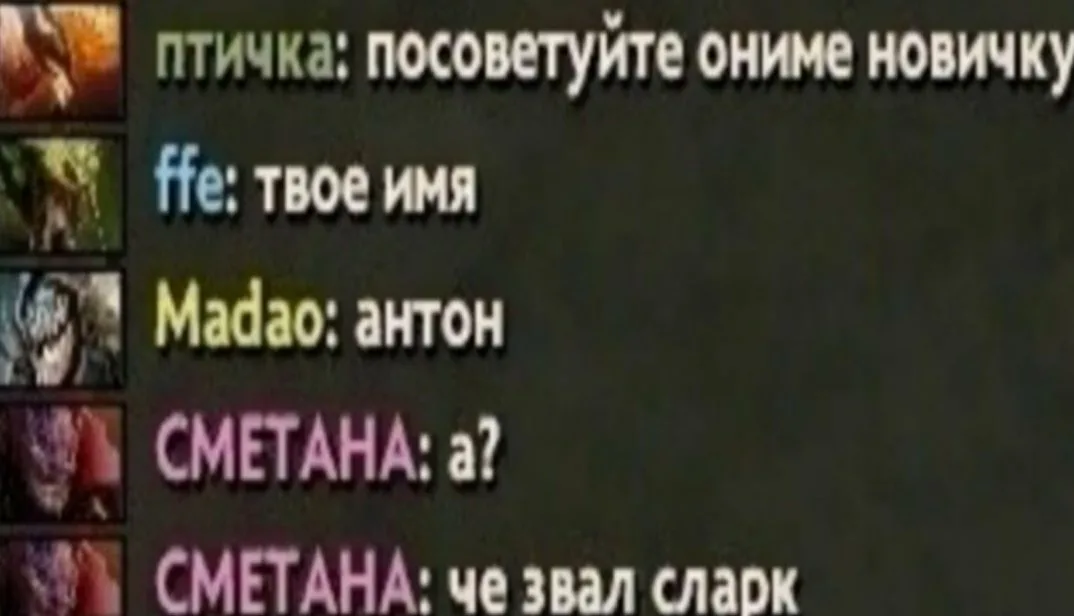

objectives_len - также не должен влиять, ведь вся информация о событиях содержится в других столбцах, а сколько их и какая у них длина - уже не важно. Единственное, что по идее, может иметь влияние - это game time. Ведь одинаковые показатели но в разное время игры совершенно по-разному влияют на ход игры: net worth 10000 на 15 минуте и на 25 - абсолютно разные вещи. Проверим это позже.

### Preprocessing (подготовка данных)

Функция для проверки результатов препроцессинга.

In [33]:
def test(X1, X2):
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    model1 = CatBoostClassifier(iterations = 1000, learning_rate = 0.1, random_seed = 42)
    cv_scores_base1 = cross_val_score(model1, X1, Y, cv=cv, scoring='roc_auc', n_jobs=-1)
    model2 = CatBoostClassifier(iterations = 1000, learning_rate = 0.1, random_seed = 42)
    cv_scores_base2 = cross_val_score(model2, X2, Y, cv=cv, scoring='roc_auc', n_jobs=-1)
    return (cv_scores_base1.mean(), cv_scores_base2.mean())


Попробуем проверить гипотезы, сделанные раннее. Сначала заменим столбцы для каждого игрока на столбцы для каждой команды. Также сразу же заполним пропуски средним. Как мы помним, пропуски в данных содержатся только в пяти столбцах, их много, удалять их точно не стоит, посмотрим на процент выбросов в этих столбцах: 

Outliers percentage in r5_kills: 2.61%

Outliers percentage in r4_kills: 2.77%

Outliers percentage in r3_kills: 2.60%

Outliers percentage in r2_kills: 2.47%

Outliers percentage in r1_kills: 2.59%

Видим, что выбросов не так много, можем заполнить средним - наиболее естественное заполнение для числовых данных. Также метрики, измеренные на тренировочных данных были лучше при заполнении средним, чем при другиз способах заполнения или вообще удаления пропусков.

In [51]:
train_x_begin = train_x.copy()
train_x = train_x.fillna(train_x.mean())
for c in ['kills', 'deaths', 'assists', 'denies', 'gold', 'lh', 'xp', 'health', 'max_mana',
           'max_health', 'level', 'stuns', 'creeps_stacked', 'camps_stacked', 'rune_pickups', 'teamfight_participation',
           'towers_killed', 'roshans_killed', 'obs_placed', 'sen_placed', 'x', 'y']:
    r_columns = [f'r{i}_{c}' for i in range(1, 6)]
    d_columns = [f'd{i}_{c}' for i in range(1, 6)]

    train_x['r_total_' + c] = train_x[r_columns].sum(1)
    train_x['d_total_' + c] = train_x[d_columns].sum(1)
    train_x['total_' + c + '_ratio'] = train_x['r_total_' + c] / train_x['d_total_' + c]
    train_x['diff_' + c] = train_x['r_total_' + c] - train_x['d_total_' + c]

    test_x['r_total_' + c] = test_x[r_columns].sum(1)
    test_x['d_total_' + c] = test_x[d_columns].sum(1)
    test_x['total_' + c + '_ratio'] = test_x['r_total_' + c] / test_x['d_total_' + c]
    test_x['diff_' + c] = test_x['r_total_' + c] - test_x['d_total_' + c]

    train_x.drop(columns=r_columns + d_columns, inplace=True)
    test_x.drop(columns=r_columns + d_columns, inplace=True)

C:\Users\pokum\AppData\Local\Temp\ipykernel_5020\3551113789.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_x['r_total_' + c] = train_x[r_columns].sum(1)
C:\Users\pokum\AppData\Local\Temp\ipykernel_5020\3551113789.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_x['d_total_' + c] = train_x[d_columns].sum(1)
C:\Users\pokum\AppData\Local\Temp\ipykernel_5020\3551113789.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

Здесь мы складываем все характеристики, которые есть у каждого игрока (кроме firstblood_claimed и hero_id) по командам. Также считаем разницу в показателях команды - с точки зрения предметной области - важный признак, так как прямо показывает преимущество одной команды над другой по всем показателям, с точки зрения машнинного обучения данный признак может помочь деревьям (в будущем увидим, что все наши модели - различные ансамбли деревьев), так как с этим признаком дерево может "сравнивать" показатели двух команд, без него деревья не могут сравнивать два признака между собой в узле. Также с точки зрения предметной области, раз уж мы добавили разницу между показателями команд, хорошо было бы добавить отношение показателей команд: одна и та же разница в золоте может иметь совершенно разное влияние на исход игры, например, разница в 10 тысяч золота может быть при net worth-ах команд: 10к и 20к, 90к и 100к. В первом случае разница является колоссальной, во втором, скорее всего незаметной. Отношение же будет это показывать - в первом случае - 0.5, во втором - 0.9. После того как мы добавили характеристики команд, удаляем характеристики каждого игрока, так как они больше нам не нужны, также ухудшалось значение roc-auc в случае, если не удалять столбцы с игроками.

In [52]:
train_x = train_x.drop(columns=['game_mode', 'objectives_len', 'lobby_type', 'chat_len', 'game_time'])
test_x = test_x.drop(columns=['game_mode', 'objectives_len', 'lobby_type', 'chat_len', 'game_time'])

c = 'firstblood_claimed'
r_columns = [f'r{i}_{c}' for i in range(1, 6)]
d_columns = [f'd{i}_{c}' for i in range(1, 6)]
train_x = train_x.drop(columns=r_columns + d_columns)
test_x = test_x.drop(columns=r_columns + d_columns)

Также удалим столбцы, которые меньше всего влияют на модель (параметры нашли ранее). Посмотрим как изменилось feature importance.

In [23]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(silent=True)
model.fit(train_x, Y)
feature_importance = pd.DataFrame({'feature': train_x.columns, 'importance':model.get_feature_importance()}).sort_values('importance')

<Axes: xlabel='importance', ylabel='feature'>

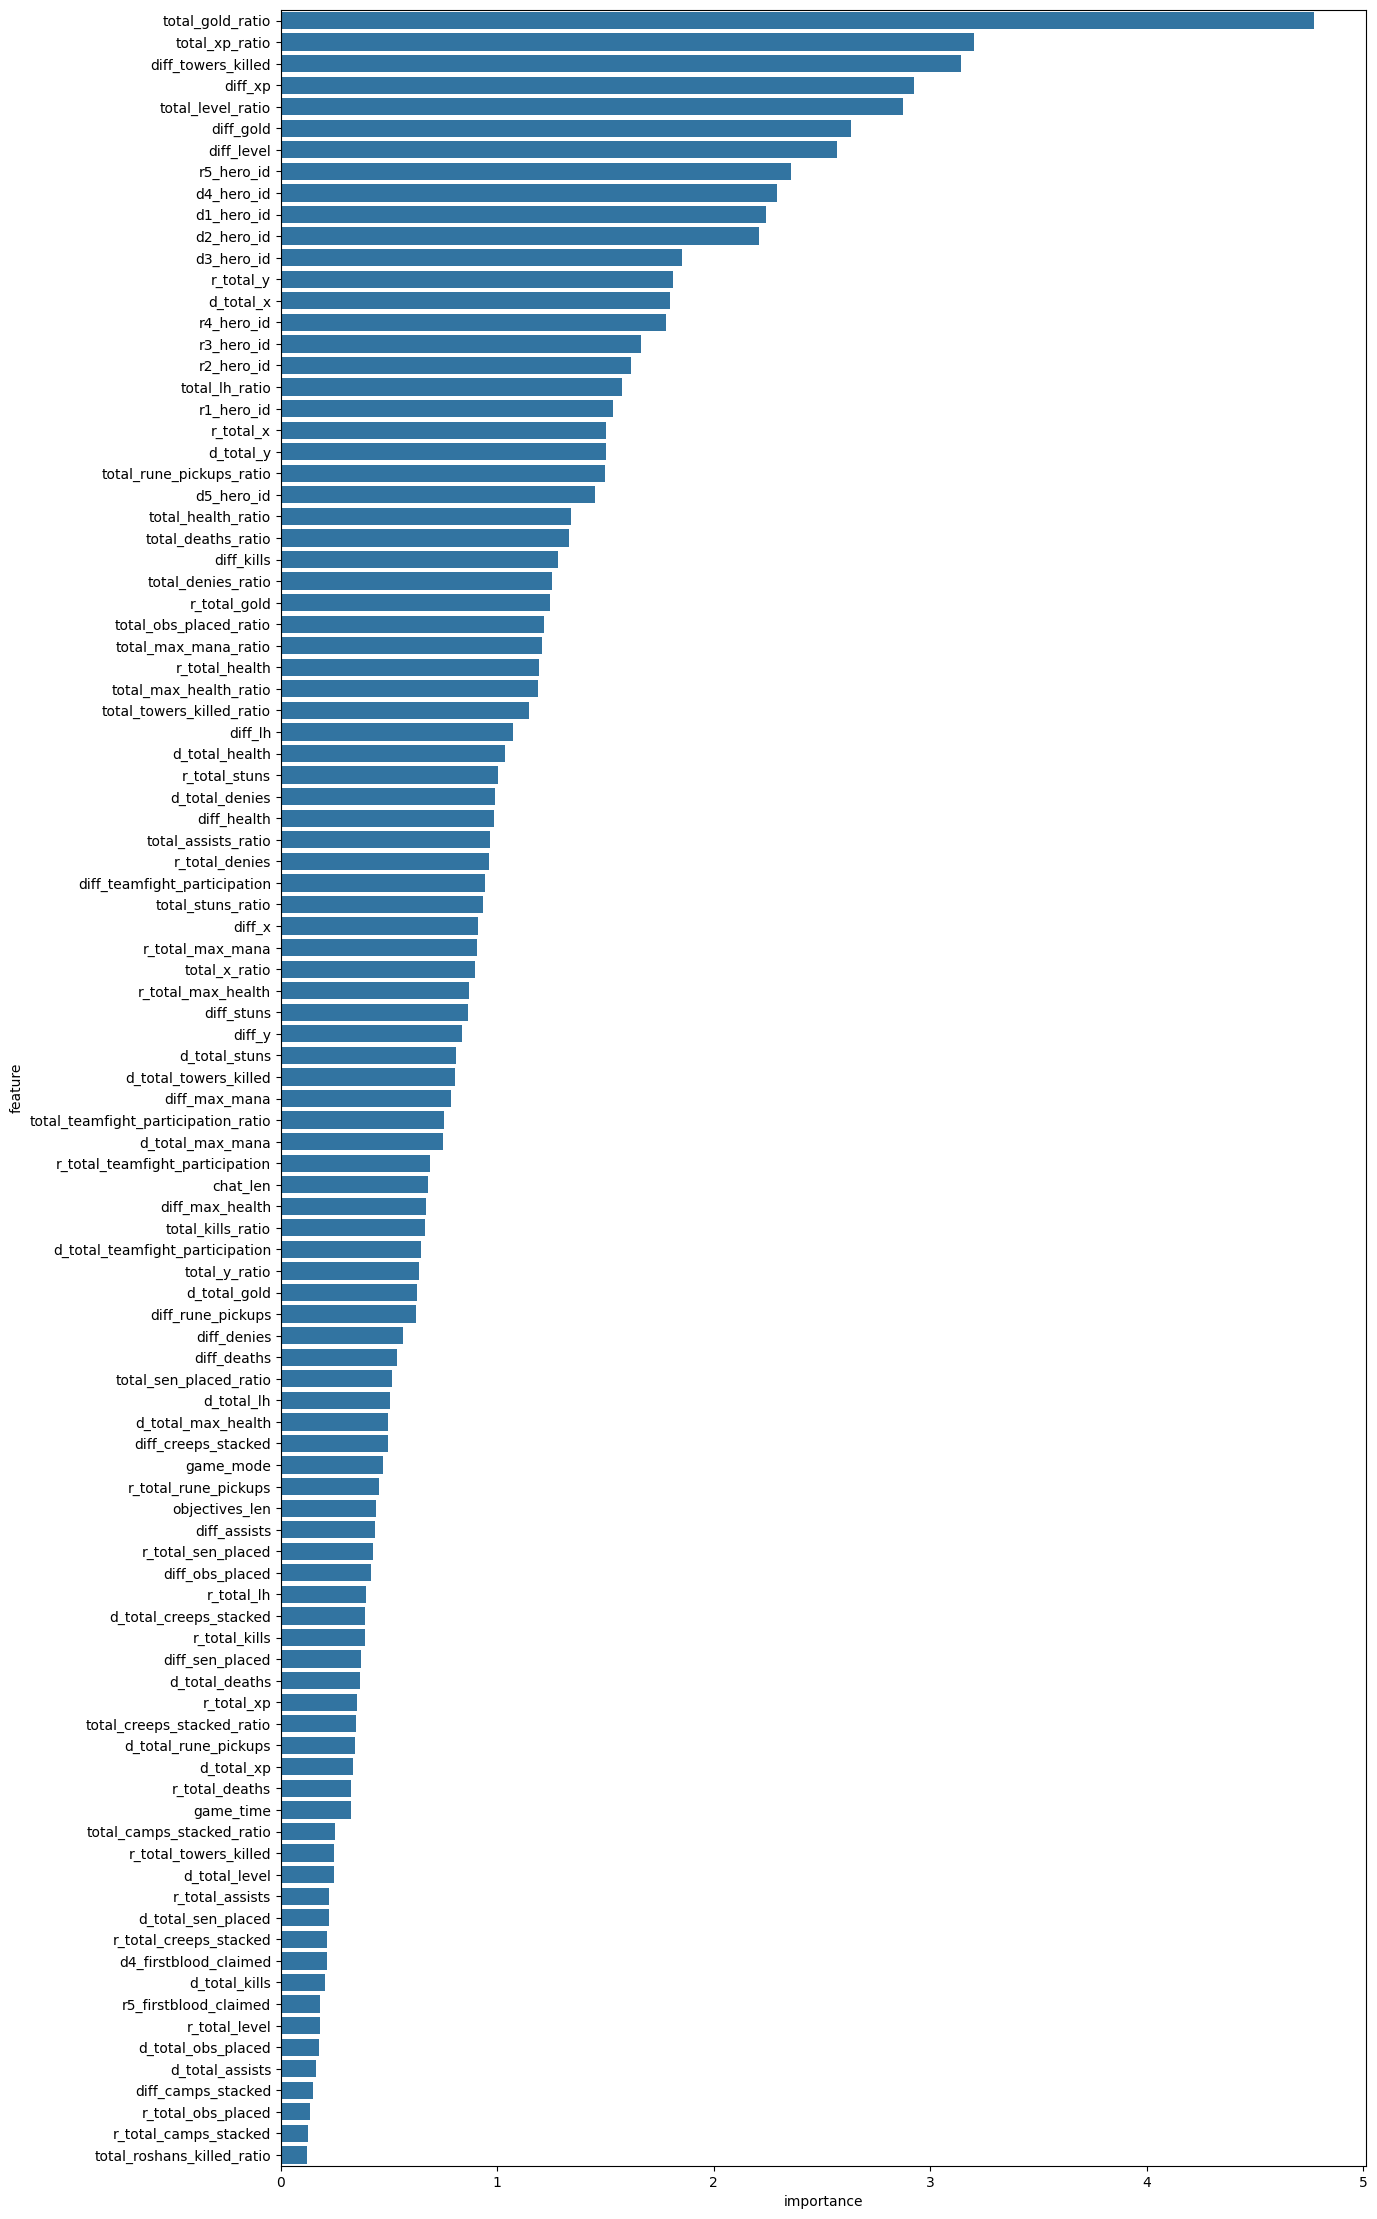

In [24]:
feature_importance = pd.DataFrame({'feature': train_x.columns, 'importance':model.get_feature_importance()}).sort_values('importance', ascending=False)[:100]
import seaborn as sns
plt.figure(figsize=(14,28))
sns.barplot(x=feature_importance.importance, y=feature_importance.feature)

In [36]:
test(train_x, train_x_begin)

(0.8131010345735474, 0.7994660682037426)

Видим, что добавленные нами признаки, теперь вносят ключевой вклад в модель. Самыми важными являются различные комбинации gold и xp команд. Добавление таких признаков значительно улучшило предсказания модели, показатель roc-auc сразу же сильно увеличился и на тренировочных, и на тестовых данных. Также заметим, что немалую роль вносят hero_id. Попробуем с этим также поработать.

hero_id - id героя, числовой признак, хотя на самом деле - это признак категориальный. Мы видим, что эти столбцы вносят сильный вклад в модель, но этот вклад, скорее всего, неправильный. В доте нет такой иерархии, где каждому герою можно сопоставить натуральное число, и чем больше число, тем лучше герой. Правильнее было бы ввести категориальный признак героя и сделать one-hot encoding. Для этого достанем информацию и героях из json.

In [19]:
df = pd.read_json("tome_of_knowledge.jsonl", lines=True)

Создадим словарь, в котором будет отображения id героя в его название.

In [25]:
map_hero_id = {}
for index, row in df.iterrows():
    map_hero_id[row['players'][0]['hero_id']] = row['players'][0]['hero_name']
map_hero_id

{11: 'npc_dota_hero_nevermore',
 15: 'npc_dota_hero_razor',
 101: 'npc_dota_hero_skywrath_mage',
 14: 'npc_dota_hero_pudge',
 42: 'npc_dota_hero_skeleton_king',
 57: 'npc_dota_hero_omniknight',
 119: 'npc_dota_hero_dark_willow',
 12: 'npc_dota_hero_phantom_lancer',
 74: 'npc_dota_hero_invoker',
 71: 'npc_dota_hero_spirit_breaker',
 35: 'npc_dota_hero_sniper',
 30: 'npc_dota_hero_witch_doctor',
 26: 'npc_dota_hero_lion',
 10: 'npc_dota_hero_morphling',
 8: 'npc_dota_hero_juggernaut',
 39: 'npc_dota_hero_queenofpain',
 103: 'npc_dota_hero_elder_titan',
 86: 'npc_dota_hero_rubick',
 44: 'npc_dota_hero_phantom_assassin',
 41: 'npc_dota_hero_faceless_void',
 9: 'npc_dota_hero_mirana',
 23: 'npc_dota_hero_kunkka',
 64: 'npc_dota_hero_jakiro',
 108: 'npc_dota_hero_abyssal_underlord',
 16: 'npc_dota_hero_sand_king',
 56: 'npc_dota_hero_clinkz',
 99: 'npc_dota_hero_bristleback',
 120: 'npc_dota_hero_pangolier',
 100: 'npc_dota_hero_tusk',
 40: 'npc_dota_hero_venomancer',
 1: 'npc_dota_hero_anti

Затем, заменим все hero_id на соответствующее название героя.

In [53]:
train_x_begin = train_x.copy()
train_x.replace({
    'r1_hero_id': map_hero_id,
    'r2_hero_id': map_hero_id,
    'r3_hero_id': map_hero_id,
    'r4_hero_id': map_hero_id,
    'r5_hero_id': map_hero_id,
    'd1_hero_id': map_hero_id,
    'd2_hero_id': map_hero_id,
    'd3_hero_id': map_hero_id,
    'd4_hero_id': map_hero_id,
    'd5_hero_id': map_hero_id
}, inplace=True)

test_x.replace({
    'r1_hero_id': map_hero_id,
    'r2_hero_id': map_hero_id,
    'r3_hero_id': map_hero_id,
    'r4_hero_id': map_hero_id,
    'r5_hero_id': map_hero_id,
    'd1_hero_id': map_hero_id,
    'd2_hero_id': map_hero_id,
    'd3_hero_id': map_hero_id,
    'd4_hero_id': map_hero_id,
    'd5_hero_id': map_hero_id
}, inplace=True)

И делаем one hot-encoding.

In [54]:
train_x = pd.get_dummies(train_x)
test_x = pd.get_dummies(test_x)

Проверим, как изменилось значение метрики на тренировочных данных с помощью кросс-валидации.

In [39]:
test(train_x, train_x_begin)

(0.8228555212824471, 0.8131010345735474)

Видим, что показатели модели улучшились. Смотреть на важность признаков теперь не имеет смысла, так как во-первых, признаков слишком много, во-вторых, по отдельности они не будут вносить значительный вклад в модель, но теперь мы уверены, что модель правильно воспринимает и интерпретирует героев. На этом финальный препроцессинг закончен. Сейчас я бы хотел рассказать о неудачных попытках.

Первой идеей было достать признаки duration и time_remaining из json для того, чтобы скомбинировать их с признаком game_time. Идея была в том, чтобы модель обучилась разной важности одинакого преимущества в разное время игры. Результаты на тренировочных данных улучшились, но на тестовых изменений особо не было, как выяснилось в последствии, в тестовых данных нет этой информации. Также была попытка добавить информацию о том, какая команда убила следующего рошана, но изменений это также не внесло.

In [ ]:
# недействительный код
next_roshan = df['targets'].apply(lambda x: x['next_roshan_team'] if pd.notna(x) and 'next_roshan_team' in x else None)
time_remaining = df['targets'].apply(lambda x: x['time_remaining'] if pd.notna(x) and 'time_remaining' in x else None)
duration = df['targets'].apply(lambda x: x['duration'] if pd.notna(x) and 'duration' in x else None)
X = pd.merge(X, next_roshan, left_index=True, right_index=True, how='left')
test_x = pd.merge(test_x, next_roshan, left_index=True, right_index=True, how='left')
X = pd.merge(X, time_remaining, left_index=True, right_index=True, how='left')
test_x = pd.merge(test_x, time_remaining, left_index=True, right_index=True, how='left')
X = pd.merge(X, duration, left_index=True, right_index=True, how='left')
test_x = pd.merge(test_x, duration, left_index=True, right_index=True, how='left')

Также была попытка достать другие признаки, но уже связанные с игроками: нанесенный ими урон, количество умерших рядом с ним крипов, предсказывал ли игрок победу, и случайным ли был выбор его героя. В теории, эти признаки (особенно урон) могли как-то повлиять на модель, но в тоге результаты либо не изменялись, либо немного ухудушались.

In [ ]:
# недействительный код
c = ['nearby_creep_death_count', 'randomed', 'pred_vict']
player_columns = []
for i in c:
    for player_id in range(0, 10):
        player_columns.append(f'r{player_id + 1}_{i}' if player_id < 6 else f'd{player_id - 4}_{i}')

new_columns_df = pd.DataFrame(columns=player_columns)

train_x = pd.concat([train_x, new_columns_df], axis=1)
test_x = pd.concat([test_x, new_columns_df], axis=1)

for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing rows"):
    match_id = row['match_id']
    for i in c:
        for player_id in range(0, 10):
            column = f'r{player_id + 1}_{i}' if player_id < 6 else f'd{player_id - 4}_{i}'
            train_x.loc[train_x.index == match_id, column] = row['players'][player_id][i]
            test_x.loc[test_x.index == match_id, column] = row['players'][player_id][i]

In [ ]:
# недействительный код
for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing rows"):
    match_id = row['match_id']
    total_damage = 0
    for i in range(1, 6):
        for j in row['players'][i-1]['damage']:
            if j.startswith('npc_dota_hero'):
                total_damage += row['players'][i-1]['damage'][j]
    train_x.loc[train_x.index == match_id, 'r_damage'] = total_damage
    test_x.loc[test_x.index == match_id, 'r_damage'] = total_damage
    total_damage = 0
    for i in range(6, 11):
        for j in row['players'][i-1]['damage']:
            if j.startswith('npc_dota_hero'):
                total_damage += row['players'][i-1]['damage'][j]
    train_x.loc[train_x.index == match_id, 'd_damage'] = total_damage
    test_x.loc[test_x.index == match_id, 'd_damage'] = total_damage

Последней идеей был парсинг предметов и их добавление каждому игроку. В теории, то, какие предметы были у игрока, должно было сильно повлиять на модель, но значение метрики лишь ухудшалось при любых попытках добавления предметов, даже в сырые данные.

In [ ]:
# недействительный код
item_columns = set()
for _, row in df.iterrows():
    for player_info in row['players']:
        if 'hero_inventory' in player_info:
            for item_dict in player_info['hero_inventory']:
                item_columns.add(item_dict['id'])

item_columns = list(item_columns)

player_columns = []
for player_id in range(1, 6):
    for item_column in item_columns:
        player_columns.append(f'r{player_id}_{item_column}')
for player_id in range(1, 6):
    for item_column in item_columns:
        player_columns.append(f'd{player_id}_{item_column}')

train_x = pd.concat([train_x] + [pd.DataFrame(columns=player_columns) for _ in range(len(train_x))], axis=1)
test_x = pd.concat([test_x] + [pd.DataFrame(columns=player_columns) for _ in range(len(test_x))], axis=1)

for index, row in df.iterrows():
    match_id = row['match_id']
    for (player_id, player_info) in zip(range(0, 10), row['players']):
        if 'hero_inventory' in player_info:
            for item_dict in player_info['hero_inventory']:
                item = item_dict['id']
                column = f"r{player_id}_{item}"
                train_x.loc[train_x.index == match_id, column] = 1
                test_x.loc[test_x.index == match_id, column] = 1

X = X.fillna(0)
test_x = test_x.fillna(0)

### Model & training (Выбор модели и её обучение)

#### Эксперимент 1

Первой моделью был RandomForestClassifier, эта модель без какого-либа препроцессинга прошла бейзлайн. Потом начался препроцессинг, но значение метрики увеличилось не сильно, поэтому были проведены эксперименты (как в анализе данных) по выбору самой лучшей модели, после этого от этой модели было решено отказаться.

In [55]:
train_x_copy = train_x.fillna(train_x.mean())
train_x_copy.replace(np.inf, 1000, inplace=True)
train_x_copy.replace(-np.inf, -1000, inplace=True)
test_x.replace(np.inf, 1000, inplace=True)
test_x.replace(-np.inf, -1000, inplace=True)

Пишем это так как не все модели могут работать с пропусками и бесконечностями, бесконечности возникают в столбцах отношений характеристик команд, заменяем бесконечность на просто большое число (большое число в рамках предметной области).

In [56]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=500, n_jobs=4, random_state=42)
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
train_x = train_x.fillna(train_x.mean())
cv_scores_base = cross_val_score(model, train_x_copy, Y, cv=cv, scoring='roc_auc', n_jobs=-1)
cv_scores_base.mean()

0.8180692912552473

#### Эксперимент 2

Лучшими моделями себя показали модели, использующие градиентный бустинг, лучшей из них была CatBoostClassifier. Эта модель была основной и именно на ней ставились все эксперименты, она показывала себя лучше во всех случаях и на тренировочных, и на тестовых данных, скорее всего, это связано с тем что CatBoost строит сбалансированные модели в отличие от других моделей градиентного бустинга.

In [57]:
from catboost import CatBoostClassifier
model = CatBoostClassifier()
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
cv_scores_base = cross_val_score(model, train_x_copy, Y, cv=cv, scoring='roc_auc', n_jobs=-1)
cv_scores_base.mean()

0.8280519739042441

#### Эксперимент 3

В последнии дни возникла острая необходимость немного повысить скор в кегле, при этом не имея каких-либо идей про препроцессингу и feature engineering-у. Тогда вспомнился метод блендинг, часто использующийся в соревнованиях. Я взял три лучшие модели градиентного бустинга и усреднил их предсказания. Скор увеличился на тестовых данных, на тренировочных данных незначительно уменьшился, поэтому было решено оставить этот подход. Также пробовал применять стекинг, но со стекингом результаты были хуже и на тестовых, и на тренировочных данных.

In [60]:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier

catboost_model = CatBoostClassifier()
xgboost_model = XGBClassifier()
lightgbm_model = LGBMClassifier()


models = [('catboost', catboost_model), ('xgboost', xgboost_model), ('lightgbm', lightgbm_model)]
voting_model = VotingClassifier(estimators=models, voting='soft')
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
cv_scores_ensemble = cross_val_score(voting_model, train_x_copy, Y, cv=cv, scoring='roc_auc', n_jobs=-1)
cv_scores_ensemble.mean()

0.8271942530959823

### Evaluation (оценка качества модели)

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

my_seed = 42
random.seed(my_seed)
np.random.seed(my_seed)

train_x = pd.read_csv("DOTA2_TRAIN_features.csv", index_col='match_id')
train_y = pd.read_csv("DOTA2_TRAIN_targets.csv", index_col='match_id')
test_x = pd.read_csv("DOTA2_TEST_features.csv", index_col='match_id')
Y = train_y[['radiant_win']]

train_x = train_x.fillna(train_x.mean())
for c in ['kills', 'deaths', 'assists', 'denies', 'gold', 'lh', 'xp', 'health', 'max_mana',
           'max_health', 'level', 'stuns', 'creeps_stacked', 'camps_stacked', 'rune_pickups', 'teamfight_participation',
           'towers_killed', 'roshans_killed', 'obs_placed', 'sen_placed', 'x', 'y']:
    r_columns = [f'r{i}_{c}' for i in range(1, 6)]
    d_columns = [f'd{i}_{c}' for i in range(1, 6)]

    train_x['r_total_' + c] = train_x[r_columns].sum(1)
    train_x['d_total_' + c] = train_x[d_columns].sum(1)
    train_x['total_' + c + '_ratio'] = train_x['r_total_' + c] / train_x['d_total_' + c]
    train_x['diff_' + c] = train_x['r_total_' + c] - train_x['d_total_' + c]

    test_x['r_total_' + c] = test_x[r_columns].sum(1)
    test_x['d_total_' + c] = test_x[d_columns].sum(1)
    test_x['total_' + c + '_ratio'] = test_x['r_total_' + c] / test_x['d_total_' + c]
    test_x['diff_' + c] = test_x['r_total_' + c] - test_x['d_total_' + c]

    train_x.drop(columns=r_columns + d_columns, inplace=True)
    test_x.drop(columns=r_columns + d_columns, inplace=True)

train_x = train_x.drop(columns=['game_mode', 'objectives_len', 'lobby_type', 'chat_len', 'game_time'])
test_x = test_x.drop(columns=['game_mode', 'objectives_len', 'lobby_type', 'chat_len', 'game_time'])

c = 'firstblood_claimed'
r_columns = [f'r{i}_{c}' for i in range(1, 6)]
d_columns = [f'd{i}_{c}' for i in range(1, 6)]
train_x = train_x.drop(columns=r_columns + d_columns)
test_x = test_x.drop(columns=r_columns + d_columns)

#df = pd.read_json("tome_of_knowledge.jsonl", lines=True)
map_hero_id = {}
for index, row in df.iterrows():
    map_hero_id[row['players'][0]['hero_id']] = row['players'][0]['hero_name']
map_hero_id

train_x.replace({
    'r1_hero_id': map_hero_id,
    'r2_hero_id': map_hero_id,
    'r3_hero_id': map_hero_id,
    'r4_hero_id': map_hero_id,
    'r5_hero_id': map_hero_id,
    'd1_hero_id': map_hero_id,
    'd2_hero_id': map_hero_id,
    'd3_hero_id': map_hero_id,
    'd4_hero_id': map_hero_id,
    'd5_hero_id': map_hero_id
}, inplace=True)

test_x.replace({
    'r1_hero_id': map_hero_id,
    'r2_hero_id': map_hero_id,
    'r3_hero_id': map_hero_id,
    'r4_hero_id': map_hero_id,
    'r5_hero_id': map_hero_id,
    'd1_hero_id': map_hero_id,
    'd2_hero_id': map_hero_id,
    'd3_hero_id': map_hero_id,
    'd4_hero_id': map_hero_id,
    'd5_hero_id': map_hero_id
}, inplace=True)

train_x = pd.get_dummies(train_x)
test_x = pd.get_dummies(test_x)

train_x.replace(np.inf, 1000, inplace=True)
train_x.replace(-np.inf, -1000, inplace=True)
test_x.replace(np.inf, 1000, inplace=True)
test_x.replace(-np.inf, -1000, inplace=True)

X_train, X_test, Y_train, Y_test = train_test_split(train_x, Y, test_size=0.2, random_state=my_seed)

catboost_model = CatBoostClassifier(silent=True)
xgboost_model = XGBClassifier()
lightgbm_model = LGBMClassifier()

models = [('catboost', catboost_model), ('xgboost', xgboost_model), ('lightgbm', lightgbm_model)]
voting_model = VotingClassifier(estimators=models, voting='soft')
voting_model.fit(train_x, Y)
y_test_predicted = voting_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(Y_test, y_test_predicted)

ensemble_probs = voting_model.predict_proba(test_x)[:, 1]
result = test_x.index
y_test_predicted = ensemble_probs
result = pd.DataFrame(list(zip(result, y_test_predicted)), columns = ['match_id', 'radiant_win'])
result.to_csv("submission.csv", index = False)

In [5]:
print(roc_auc)
result.head()

0.9375928318921005


,match_id,radiant_win
0,3071feff2631bd8ca93d0d182e5b9249,0.609285
1,785b46a41ad7fc643b2fe870e18435e9,0.038131
2,4856a3ccfd84dbd0ab25c0529815978e,0.679734
3,bea45c19efef0f86c03a70280380185d,0.973540
4,77859b5baddd3a6d0cb05721d9494456,0.958398


In [7]:
voting_model.fit(X_train, Y_train)
y_test_predicted = voting_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(Y_test, y_test_predicted)
ensemble_probs = voting_model.predict_proba(test_x)[:, 1]
result = test_x.index
y_test_predicted = ensemble_probs
result = pd.DataFrame(list(zip(result, y_test_predicted)), columns = ['match_id', 'radiant_win'])
result.to_csv("submission.csv", index = False)

c:\Users\pokum\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\pokum\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 11652, number of negative: 10565
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17670
[LightGBM] [Info] Number of data points in the train set: 22217, number of used features: 1237
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.524463 -> initscore=0.097931
[LightGBM] [Info] Start training from score 0.097931
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent


In [8]:
print(roc_auc)
result.head()

0.8286397563291787


,match_id,radiant_win
0,3071feff2631bd8ca93d0d182e5b9249,0.613763
1,785b46a41ad7fc643b2fe870e18435e9,0.039985
2,4856a3ccfd84dbd0ab25c0529815978e,0.661318
3,bea45c19efef0f86c03a70280380185d,0.980824
4,77859b5baddd3a6d0cb05721d9494456,0.957634


Обучали на полной выборке, так как данных не так много, и это сильно улучшало результаты на тестовых данных (public). В качестве финальной модели выступает VotingClassifier (voting='soft' - предсказания это усреднение предсказаний моделей) с тремя моделями - CatBoostClassifier, XGBClassifier, LGBMClassifier со стандартными параметрами. Обучение на полной выборке дает roc-auc на тренировочных данных - почти 0.94, в kaggle - 0.831. Обучение на неполной выборке дает roc-auc на тренировочных данных - почти 0.83, в kaggle - 0.832.

### Conclusion (Выводы)

Получили хорошую модель, в достижении этого результата сильно помогло, во-первых, понимание предметной области, было легко интерпретировать признаки, добавлять новые, удалять ненужные, строить новые гипотезы, так как многие из них были выдвинуты на основе опыта игры, во-вторых, сильно помогли ансамблевые модели, они без особого труда проходили бейзлайн без каких-либо манипуляций с данными, да и работать с ними было приятно - не нужно обрабатывать пропуски, категориальные и другие значения, работа с которыми бы принесла проблем. Получилось на практике увидеть превосходство моделей градиентного бустинга, а также применить популярные в соревнованиях методы - блендинг и стекинг. Было интересно покопаться с данными своей "любимой" игры и на самом деле узнать, что влияет на победу больше всего.

Не получилось добиться лучшего результата: многие гипотезы не оправдали себя. На самом деле, опыт игры также явлется и минусом. Опытный игрок видит больше возможностей, но не все из них помогают найти нужные зависимости, ты пытаешься попробовать все и сразу, но при этом, возможно, теряешь вклад по-настоящему важных признаков, а опробовать все гипотезы было очень сложно, в связи с огромным размером данных, хранящихся в json, и слабыми вычислительными мощностями по его парсингу. 

В целом, результатами работы доволен, на практике познакомился с ансамблевыми моделями, попробовал много гипотез, хоть не все из них оправдали себя, было интересно столкнуться с такими большими объемами данных, а особенно по игре дота 2.

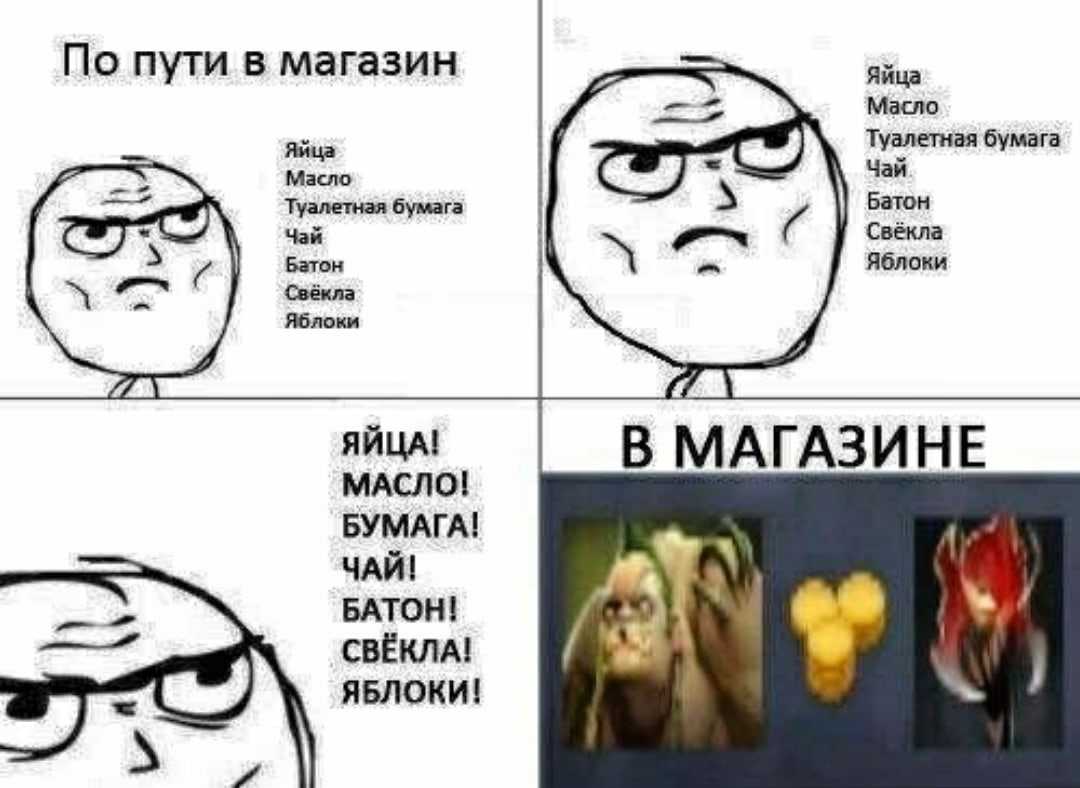